In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from Element_PI import VariancePersistv1
import glob
from datetime import datetime
import tensorboard
%load_ext tensorboard


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [3]:
px = 32
py = 32
spread = 1      #varience or std, not sure
axis_bound = 2.5  #angstroms
samples = 500

data_path = '../iMoDELS-supplements/data/raw-data/everything.csv'
data = pd.read_csv(data_path, index_col=0)
data = data.drop(['backbone'],axis=1)

molecules = glob.glob('../terminal_group_screening/src/util/molecules/*.xyz')
molecules = list(set(molecules))
im_mols = {}
for m in molecules:
    mol_name = m.split('/')[-1].split('.')[0]
    if 'ch3' in mol_name:
        mol_name = mol_name.split('-')[0]
        im_mols[mol_name] = VariancePersistv1(m, pixelx=px, pixely=py, myspread=spread, myspecs={"maxBD": axis_bound, "minBD":-.10}, showplot=False).reshape(px,py, 1)
        im_mols[mol_name] = np.asarray(im_mols[mol_name]).astype('float32')

def str_to_im(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        return im_mols[chem_name]
        
data.terminal_group_1 = data.terminal_group_1.apply(str_to_im)
data.terminal_group_2 = data.terminal_group_2.apply(str_to_im)
data.terminal_group_3 = data.terminal_group_3.apply(str_to_im)
data = data.dropna()


msk = np.random.rand(len(data)) < 0.8
train, test = data[msk] , data[~msk]

train_X, train_y = train, train['COF']
train_X = train_X.drop(['COF'],axis=1)
test_X, test_y = test, test['COF']

In [8]:
input_t1 = keras.Input(shape=(px, py, 1))
x = keras.layers.Conv2D(8, 5)(input_t1)
x = keras.layers.Conv2D(8, 4)(x)
x = keras.layers.Conv2D(8, 3)(x)
x = keras.layers.Flatten()(x)
model_x = keras.Model(inputs = input_t1, outputs=x)

input_t2 = keras.Input(shape=(px, py, 1))
y = keras.layers.Conv2D(8, 5)(input_t2)
y = keras.layers.Conv2D(8, 4)(y)
y = keras.layers.Conv2D(8, 3)(y)
y = keras.layers.Flatten()(y)
model_y = keras.Model(inputs = input_t2, outputs=y)

input_t3 = keras.Input(shape=(px, py, 1))
z = keras.layers.Conv2D(8, 5)(input_t3)
z = keras.layers.Conv2D(8, 4)(z)
z = keras.layers.Conv2D(8, 3)(z)
z = keras.layers.Flatten()(z)
model_z = keras.Model(inputs = input_t3, outputs=z)

meta_dat = keras.Input(shape=(111,))
m = keras.layers.Dense(512, activation ='relu')(meta_dat)
m = keras.layers.Dense(256, activation ='relu')(m)
model_m = keras.Model(inputs = meta_dat, outputs=m)

combo = keras.layers.concatenate([model_x.output, model_y.output, model_z.output, model_m.output])

out = keras.layers.Dense(512, activation='relu')(combo)
out = keras.layers.Dense(256, activation='relu')(combo)
out = keras.layers.Dense(1, activation='linear')(out)

logdir="logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = keras.Model(inputs=[input_t1, input_t2, input_t3, meta_dat], outputs=out)
model.compile(optimizer='Adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(
    x = [np.array(train_X['terminal_group_1'].to_list()),
    np.array(train_X['terminal_group_2'].to_list()),
    np.array(train_X['terminal_group_3'].to_list()),
    np.array(train_X[train_X.columns[3:].to_list()])], 
    y = np.array(train_y.to_list()),
    epochs=10,
    validation_data=([np.array(test_X['terminal_group_1'].to_list()),
    np.array(test_X['terminal_group_2'].to_list()),
    np.array(test_X['terminal_group_3'].to_list()),
    np.array(test_X[train_X.columns[3:].to_list()])], np.array(test_y.to_list())),
    callbacks=[tensorboard_callback])

Epoch 1/10
146/146 [==============================] - 18s 116ms/step - loss: 15.5051 - root_mean_squared_error: 3.9377 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854
Epoch 2/10
146/146 [==============================] - 18s 125ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0723
Epoch 3/10
146/146 [==============================] - 17s 114ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 4/10
146/146 [==============================] - 15s 101ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 5/10
146/146 [==============================] - 14s 93ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 6/10
146/146 [==============================] - 12s 85ms/step - loss: 8.8828e-04 - root_mean_squared_error: 0.0298 - va

Text(0, 0.5, 'COF')

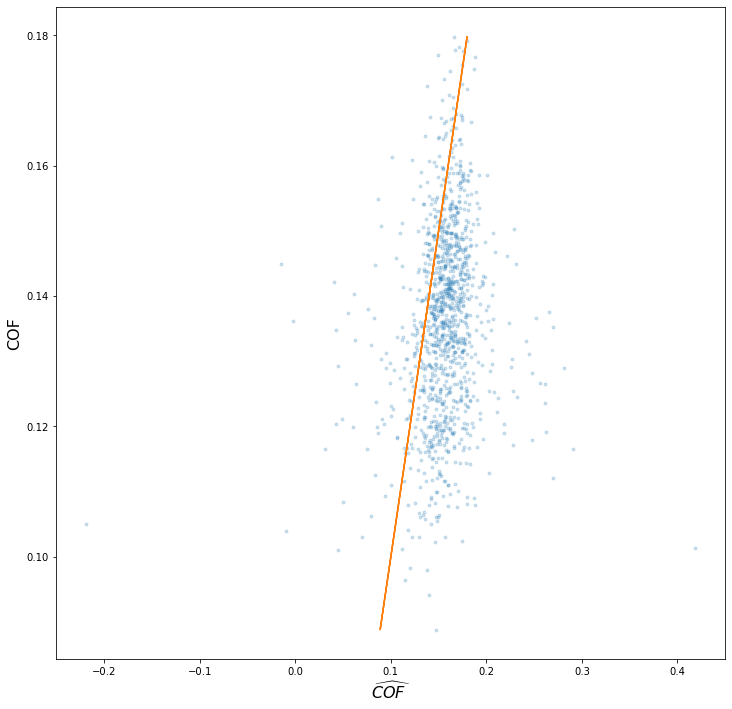

In [10]:
test_pred = model([np.array(test_X['terminal_group_1'].to_list()),
    np.array(test_X['terminal_group_2'].to_list()),
    np.array(test_X['terminal_group_3'].to_list()),
    np.array(test_X[train_X.columns[3:].to_list()])], np.array(test_y.to_list()))

plt.figure(figsize=(12,12))
plt.plot(test_pred, test_y,'.', alpha=.2)
plt.plot(test_y,test_y,'-')
plt.xlabel('$\widehat{COF}$', fontsize=16)
plt.ylabel('COF', fontsize=16)

In [22]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/Users/kieran/opt/miniconda3/envs/pred_modeling/bin/tensorboard", line 6, in <module>
    from tensorboard.main import run_main
  File "/Users/kieran/opt/miniconda3/envs/pred_modeling/lib/python3.10/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/Users/kieran/opt/miniconda3/envs/pred_modeling/lib/python3.10/site-packages/tensorboard/default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/Users/kieran/opt/miniconda3/envs/pred_modeling/lib/python3.10/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 23, in <module>
    from tensorboard import plugin_util
  File "/Users/kieran/opt/miniconda3/envs/pred_modeling/lib/python3.10/site-packages/tensorboard/plugin_util.py", line 20, in <module>
    from tensorboard._vendor.bleach.sanitizer import Cleaner
  File "/Users/kiera